In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import jacobian
import scipy
import matplotlib.pyplot as plt

In [2]:
def kl_mvn(to, fr):
    """Calculate `KL(to||fr)`, where `to` and `fr` are pairs of means and covariance matrices"""
    m_to, S_to = to
    m_fr, S_fr = fr
    
    d = m_fr - m_to
    
    c, lower = scipy.linalg.cho_factor(S_fr)
    def solve(B):
        return scipy.linalg.cho_solve((c, lower), B)
    
    def logdet(S):
        return np.linalg.slogdet(S)[1]

    term1 = np.trace(solve(S_to))
    term2 = logdet(S_fr) - logdet(S_to)
    term3 = d.T @ solve(d)
    return (term1 + term2 + term3 - len(d))/2.

In [3]:

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)     # Outputs the mean
        self.fc_short_encode = nn.Linear(input_dim, latent_dim)    # shortcut to the latent space

        self.fc_logvar = nn.Linear(hidden_dim, latent_dim) # Outputs the log variance

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        self.fc_short_decode = nn.Linear(latent_dim, input_dim)    # shortcut to the input space

    def encode(self, x):
        """Encodes input by mapping it into the latent space."""
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1) + self.fc_short_encode(x)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Applies the reparameterization trick to sample from N(mu, var)."""
        std = torch.exp(0.5 * logvar)   # Calculate the standard deviation
        eps = torch.randn_like(std)     # Sample from standard normal
        return mu + eps * std           # Sample from N(mu, var)

    def decode(self, z):
        """Decodes the latent representation z to reconstruct the input."""
        h3 = F.relu(self.fc3(z))
        # x_recon = torch.sigmoid(self.fc4(h3))
        x_recon = self.fc4(h3) + self.fc_short_decode(z)

        return x_recon

    def forward(self, x):
        """Defines the computation performed at every call."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    """Computes the VAE loss function."""
    # Reconstruction loss (binary cross entropy)
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence between the approximate posterior and the prior
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.05

    # KLD = 0

    return MSE + KLD


In [4]:
seed = 1
n = 200000
d = 10

np.random.seed(seed)
# A1_vector = np.random.normal(0, 1, d)
# A2_vector = np.random.normal(0, 1, d)

A1_vector = np.random.uniform(0.8, 1.2, d)
A2_vector = np.random.uniform(0.8, 1.2, d)

A1 = np.diag(A1_vector)
A2 = np.diag(A2_vector)

B1 = np.random.normal(0, 1, d)
B2 = np.random.normal(0, 1, d)

In [5]:
np.random.seed(seed)
X = np.random.normal(0, 1, (n, d))
Y1 = X * A1_vector + B1
Y2 = X * A2_vector + B2
Y = np.random.normal(0, 1, (n, d))


Y1 = torch.from_numpy(Y1).float()
Y2 = torch.from_numpy(Y2).float()
Y = torch.from_numpy(Y).float()

In [6]:
g1_inverse_true = (Y - B1) / A1_vector
g2_inverse_true = (Y - B2) / A2_vector
d1 = d
d2 = d

In [7]:
g1_inverse_true.pow(2).sum(1)

tensor([13.5349, 36.4740, 12.3655,  ..., 12.2571, 12.9371, 20.3265],
       dtype=torch.float64)

In [8]:
g2_inverse_true.pow(2).sum(1)

tensor([11.6004, 29.1244, 11.9660,  ..., 16.4414, 12.7913,  7.2787],
       dtype=torch.float64)

In [9]:

from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
input_dim = Y1.size(1)   # Dimension of the input data
hidden_dim = 50        # Size of the hidden layer
latent_dim = 10         # Dimension of the latent space
batch_size = 100        # Batch size for training
learning_rate = 5e-3    # Learning rate
epochs = 50             # Number of training epochs




In [10]:
# Create DataLoader
dataset1 = TensorDataset(Y1)
dataloader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True)

# Initialize the VAE model
model1 = VAE(input_dim, hidden_dim, latent_dim)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=1e-3)

# Training loop
for epoch in range(epochs):
    model1.train()
    train_loss = 0
    for data_batch in dataloader1:
        data = data_batch[0]
        optimizer1.zero_grad()
        recon_batch, mu, logvar = model1(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss = loss / batch_size
        loss.backward()
        train_loss += loss.item() * batch_size
        optimizer1.step()
    average_loss = train_loss / len(dataset1)
    print(f'Epoch {epoch + 1}, Average Loss: {average_loss:.4f}')

/Users/yansun/opt/anaconda3/envs/llmenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1, Average Loss: 1.3565
Epoch 2, Average Loss: 1.1508
Epoch 3, Average Loss: 1.1480
Epoch 4, Average Loss: 1.1464
Epoch 5, Average Loss: 1.1446
Epoch 6, Average Loss: 1.1443
Epoch 7, Average Loss: 1.1432
Epoch 8, Average Loss: 1.1432
Epoch 9, Average Loss: 1.1429
Epoch 10, Average Loss: 1.1428
Epoch 11, Average Loss: 1.1426
Epoch 12, Average Loss: 1.1418
Epoch 13, Average Loss: 1.1417
Epoch 14, Average Loss: 1.1421
Epoch 15, Average Loss: 1.1422
Epoch 16, Average Loss: 1.1418
Epoch 17, Average Loss: 1.1420
Epoch 18, Average Loss: 1.1418
Epoch 19, Average Loss: 1.1414
Epoch 20, Average Loss: 1.1413
Epoch 21, Average Loss: 1.1415
Epoch 22, Average Loss: 1.1417
Epoch 23, Average Loss: 1.1411
Epoch 24, Average Loss: 1.1414
Epoch 25, Average Loss: 1.1415
Epoch 26, Average Loss: 1.1412
Epoch 27, Average Loss: 1.1411
Epoch 28, Average Loss: 1.1408
Epoch 29, Average Loss: 1.1413
Epoch 30, Average Loss: 1.1414
Epoch 31, Average Loss: 1.1420
Epoch 32, Average Loss: 1.1413
Epoch 33, Average

In [11]:
print((Y - model1.decode(model1.encode(Y)[0])).pow(2).sum(1).mean())
print((Y2 - model1.decode(model1.encode(Y2)[0])).pow(2).sum(1).mean())
print((Y1 - model1.decode(model1.encode(Y1)[0])).pow(2).sum(1).mean())

tensor(0.0278, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)


In [12]:
print(np.power(model1.encode(Y1)[0].data, 2).sum(1).mean())
print(np.power((Y1 - B1) / A1_vector, 2).sum(1).mean())

print(np.power(model1.encode(Y)[0].data, 2).sum(1).mean())
print(np.power((Y - B1) / A1_vector, 2).sum(1).mean())

print(np.power(model1.encode(Y2)[0].data, 2).sum(1).mean())
print(np.power((Y2 - B1) / A1_vector, 2).sum(1).mean())

tensor(9.8003)
tensor(9.9893, dtype=torch.float64)
tensor(19.2514)
tensor(19.9927, dtype=torch.float64)
tensor(18.3882)
tensor(19.0144, dtype=torch.float64)


In [13]:
# Create DataLoader
dataset2 = TensorDataset(Y2)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

# Initialize the VAE model
model2 = VAE(input_dim, hidden_dim, latent_dim)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=1e-3)

# Training loop
for epoch in range(epochs):
    model2.train()
    train_loss = 0
    for data_batch in dataloader2:
        data = data_batch[0]
        optimizer2.zero_grad()
        recon_batch, mu, logvar = model2(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss = loss / batch_size
        loss.backward()
        train_loss += loss.item() * batch_size
        optimizer2.step()
    average_loss = train_loss / len(dataset2)
    print(f'Epoch {epoch + 1}, Average Loss: {average_loss:.4f}')

Epoch 1, Average Loss: 1.3328
Epoch 2, Average Loss: 1.1711
Epoch 3, Average Loss: 1.1683
Epoch 4, Average Loss: 1.1672
Epoch 5, Average Loss: 1.1658
Epoch 6, Average Loss: 1.1659
Epoch 7, Average Loss: 1.1648
Epoch 8, Average Loss: 1.1647
Epoch 9, Average Loss: 1.1638
Epoch 10, Average Loss: 1.1640
Epoch 11, Average Loss: 1.1634
Epoch 12, Average Loss: 1.1642
Epoch 13, Average Loss: 1.1632
Epoch 14, Average Loss: 1.1636
Epoch 15, Average Loss: 1.1635
Epoch 16, Average Loss: 1.1634
Epoch 17, Average Loss: 1.1630
Epoch 18, Average Loss: 1.1635
Epoch 19, Average Loss: 1.1629
Epoch 20, Average Loss: 1.1630
Epoch 21, Average Loss: 1.1633
Epoch 22, Average Loss: 1.1628
Epoch 23, Average Loss: 1.1631
Epoch 24, Average Loss: 1.1631
Epoch 25, Average Loss: 1.1631
Epoch 26, Average Loss: 1.1634
Epoch 27, Average Loss: 1.1631
Epoch 28, Average Loss: 1.1625
Epoch 29, Average Loss: 1.1626
Epoch 30, Average Loss: 1.1627
Epoch 31, Average Loss: 1.1625
Epoch 32, Average Loss: 1.1624
Epoch 33, Average

In [14]:
print((Y - model2.decode(model2.encode(Y)[0])).pow(2).sum(1).mean())
print((Y2 - model2.decode(model2.encode(Y2)[0])).pow(2).sum(1).mean())
print((Y1 - model2.decode(model2.encode(Y1)[0])).pow(2).sum(1).mean())

tensor(0.0226, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0341, grad_fn=<MeanBackward0>)


In [15]:
print(np.power(model2.encode(Y2)[0].data, 2).sum(1).mean())
print(np.power((Y2 - B2) / A2_vector, 2).sum(1).mean())

print(np.power(model2.encode(Y)[0].data, 2).sum(1).mean())
print(np.power((Y - B2) / A2_vector, 2).sum(1).mean())

print(np.power(model2.encode(Y1)[0].data, 2).sum(1).mean())
print(np.power((Y1 - B2) / A2_vector, 2).sum(1).mean())

tensor(9.8971)
tensor(9.9893, dtype=torch.float64)
tensor(15.2488)
tensor(15.5987, dtype=torch.float64)
tensor(17.8243)
tensor(18.0450, dtype=torch.float64)


In [16]:
num_samples = 1000

In [17]:
def g1_inverse_g2_function(x):
    mu, _ = model1.encode(model2.decode(x))
    return mu

In [18]:
delta_list = []
std_list = []
for seed in range(100):
    if seed % 10 == 0:
        print(seed)
    np.random.seed(seed)
    # X = np.random.normal(0, 1, (n, d))
    # Y1 = X * A1_vector + B1
    # Y2 = X * A2_vector + B2
    Y = np.random.normal(0, 1, (n, d))
    Y = torch.from_numpy(Y).float()

    # g1_inverse = (Y - B1) / A1_vector
    # g2_inverse = (Y - B2) / A2_vector

    g1_inverse = model1.encode(Y)[0].data
    g2_inverse = model2.encode(Y)[0].data
    d1 = d
    d2 = d

    log_jacobian_list = []
    for index in range(num_samples):
        # if index % 10 == 0:
        #     print(index)
        z = torch.clone(g2_inverse[index:index+1,].data)
        z.requires_grad = True
        J_g1_inverse_g2 = jacobian(g1_inverse_g2_function, z)
        jacobian_g1_inverse_g2 = z.grad
        log_jacobian_list.append(torch.log(torch.det(J_g1_inverse_g2[0,:,0,:]).abs()).item())


    # delta_pp = np.log(np.abs(A2_vector / A1_vector)).sum() -0.5 * np.power(g1_inverse, 2).sum(1).mean() + 0.5 * np.power(g2_inverse, 2).sum(1).mean() + (d2 - d1) * np.log(2 * np.pi)
    # std_pp = (-0.5 * np.power(g1_inverse, 2).sum(1) + 0.5 * np.power(g2_inverse, 2).sum(1)).std() / np.sqrt(n)

    delta_pp = torch.FloatTensor(log_jacobian_list) -0.5 * np.power(g1_inverse, 2).sum(1)[0:num_samples]+ 0.5 * np.power(g2_inverse, 2).sum(1)[0:num_samples] + (d2 - d1) * np.log(2 * np.pi)
    std_pp = delta_pp.std()
    delta_pp = delta_pp.mean()

    delta_list.append(delta_pp)
    std_list.append(std_pp)

0
10
20
30
40
50
60
70
80
90


In [24]:
print(-0.5 * np.power((Y - B1) / A1_vector, 2).sum(1).mean() + 0.5 * np.power((Y - B2) / A2_vector, 2).sum(1).mean() + (d2 - d1) * np.log(2 * np.pi))
print(-0.5 * np.power(g1_inverse, 2).sum(1).mean() + 0.5 * np.power(g2_inverse, 2).sum(1).mean() + (d2 - d1) * np.log(2 * np.pi))


tensor(-2.1964, dtype=torch.float64)
tensor(-2.0011)


In [25]:
print(torch.FloatTensor(log_jacobian_list).mean())
print(np.log(np.abs(A2_vector / A1_vector)).sum())

tensor(0.0759)
0.42535272172772054


In [27]:
# plt.hist(torch.FloatTensor(log_jacobian_list))

In [28]:
# delta_list

(array([ 5.,  9.,  7., 17., 22., 15.,  9.,  9.,  3.,  4.]),
 array([-2.16974306, -2.12054729, -2.07135153, -2.02215576, -1.97295988,
        -1.92376411, -1.87456834, -1.82537258, -1.77617669, -1.72698092,
        -1.67778516]),
 <BarContainer object of 10 artists>)

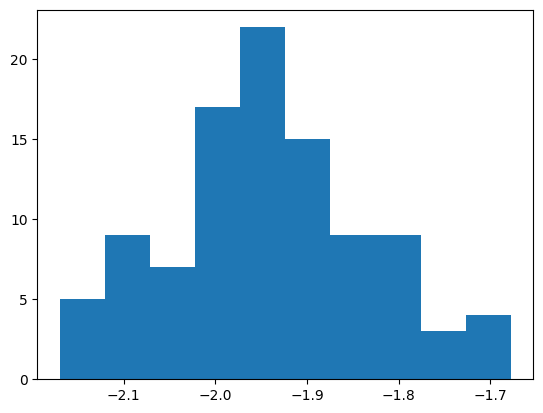

In [29]:
# histgoram of unnormalized statistics
plt.hist(delta_list)

In [30]:
mu = np.zeros(d)
sigma = np.diag(np.ones(d))

dist = -kl_mvn((mu, sigma), (B1, np.power(A1, 2))) + kl_mvn((mu, sigma), (B2, np.power(A2, 2)))
print(dist)

-1.7695912004473735


(array([ 1.,  9.,  9., 15., 24., 17.,  8., 10.,  3.,  4.]),
 array([-4.23204899, -3.71496224, -3.1978755 , -2.68078876, -2.16370201,
        -1.64661515, -1.1295284 , -0.61244166, -0.09535489,  0.42173186,
         0.93881863]),
 <BarContainer object of 10 artists>)

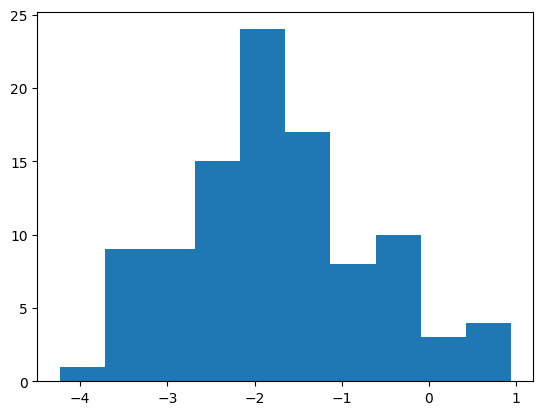

In [31]:
# histgoram of test statistics
plt.hist((np.array(delta_list) - dist) / (np.array(std_list) / np.sqrt(num_samples)))

In [32]:
# print((Y - model1.decode(model1.encode(Y)[0])).pow(2).sum(1).mean())
# print((Y2 - model1.decode(model1.encode(Y2)[0])).pow(2).sum(1).mean())
# print((Y1 - model1.decode(model1.encode(Y1)[0])).pow(2).sum(1).mean())

# print((Y - model2.decode(model2.encode(Y)[0])).pow(2).sum(1).mean())
# print((Y2 - model2.decode(model2.encode(Y2)[0])).pow(2).sum(1).mean())
# print((Y1 - model2.decode(model2.encode(Y1)[0])).pow(2).sum(1).mean())